In [96]:
##imports from libraries
%tensorflow_version 1.x
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import resource
import time
import math
import os
import sys
import cvxpy
import keras
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing
from multiprocessing import Process, Pipe
from multiprocessing.pool import ThreadPool
from torchvision import datasets, transforms
from keras.datasets import mnist
from random import randint

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
## Preprocessing of data
# Load data here:
image_size = 784
num_classes = 10
num_worker = 10
max_iter = 15
lambda_ = 1
delta = 1
a_k = 0.005
a_k2 = 0.0005
a_k3 = 0.00005
# Load data here:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], image_size).T
x_test = x_test.reshape(x_test.shape[0], image_size).T

x_train = x_train/255.0
x_test = x_test/255.0

# #Split dataset to 10 partitions
def split_workers(X_data, y_data, num_worker):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y_data)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[:,i:j]
        y_data_worker = y_data[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
        
    return data_X_list, data_y_list

workers_x, workers_y = split_workers(x_train, y_train, num_worker)

In [0]:
# ------------------------- SVM Classificaton ----------------------------------

#multiclass SVM classification loss and its gradient
def SVM_classify(x, w):
    return np.argmax(np.matmul(x.T, w), axis = 1).reshape(x.shape[1], 1)

def SVM_cost(x, y, w):
    svm_cost = (np.matmul(x.T, w) - np.repeat(np.multiply(x.T, w[:,y.reshape(y.shape[0])].T).sum(axis = 1).reshape(y.shape[0], 1), 10, axis = 1) + delta).clip(min = 0)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] = 0
    return svm_cost

def regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum() + lambda_/2 * np.linalg.norm(w)**2

def SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad_coef = svm_cost
    svm_cost_grad_coef[(range(y.shape[0]), y.reshape(y.shape[0]))] -= svm_cost.sum(axis=1)
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_grad[:, i] = np.multiply(svm_cost_grad_coef[:, i].reshape(svm_cost_grad_coef.shape[0], 1), x.T).sum(axis = 0)
    return svm_cost_grad


#binary SVM classification one-vs-rest loss and its gradient
def bin_SVM_classify(x, w):
    scores = np.matmul(x.T, w)
    class_votes = np.zeros(scores.shape())
    class_votes[scores > 0] += 1
    for i in range(10):
        class_votes[scores[:,i] <= 0,:] += 1
    class_votes[scores <= 0] -= 1
    return np.argmax(class_votes, axis = 1).reshape(x.shape[1], 1)
            
def bin_SVM_cost(x, y, w):
    svm_cost = - np.matmul(x.T, w)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] *= -1
    return (1 - svm_cost).clip(min = 0)

def bin_regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum(axis = 1) + lambda_/2 * np.linalg.norm(w, axis = 1)**2

def bin_SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_yi = svm_cost[:, i]
        svm_cost_yi[y == i] *= -1
        svm_cost_grad[:, i] = np.multiply(x, svm_cost_yi.T).sum(axis = 0) + lambda_ * w[:, i]
    return svm_cost_grad

#plot loss vs signaling at master node
def plot_master_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 1, len(curves[k]))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        T, loss = zip(*errs)
        plt.plot(T, loss, color = next(colors))
        legends.append(legend)
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    plt.title('Convergence vs signaling (%s)' % k)
    if len(legends) > 1:
        plt.legend(legends)
    plt.show()
    
    
#plot greyscale plots of computed models of each digit
def plot_w_ks(w_k):
    fig, axarr = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        axarr[int(i / 5), int(i % 5)].imshow(w_k[:28*28,i].reshape(28, 28), cmap='gray', interpolation='none')
        axarr[int(i / 5), int(i % 5)].set_title("Digit: {}".format(i))
        axarr[int(i / 5), int(i % 5)].set_xticks([])
        axarr[int(i / 5), int(i % 5)].set_yticks([])
    plt.show()
    
#plot average agent loss vs signaling and the region between min and max loss
def plot_agents_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 10, len(curves[k].keys()))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        color = next(colors)
        T, losses = zip(*errs)
        legends.append(legend)
        losses = np.array(losses)
        mean = np.array(losses).mean(axis = 1)
        lmin = np.array(losses).min(axis = 1)
        lmax = np.array(losses).max(axis = 1)
        var = np.array(losses).var(axis = 1)
        plt.plot(np.array(T), mean, color = color)
    plt.fill_between(T, lmin, lmax,facecolor = color, alpha=0.2, edgecolor='none')
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    if len(legends) > 1:
        plt.legend(legends)
    plt.title('Convergence vs signaling (%s)' % k)
    plt.show()
    
    #single agent GD SVM
def gradient_descent(x, y, w_k, lambda_, a_k, max_iter):
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs 

#single agent binary GD SVM
def bin_gradient_descent(x, y, w_k, lambda_, a_k, max_iter):
    L1 = np.linalg.norm(bin_regulated_total_cost(x, y, w_k, lambda_))
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = bin_SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = np.linalg.norm(regulated_total_cost(x, y, w_k, lambda_))
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs 

In [0]:
## CA5---------------------------- Part (a)------------------------------------------------------------------------------

#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data adding noise with probability p :
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    grad_w = SVM_cost_grad(x, y, w_k, lambda_)
    return 1, np.array(grad_w) 


def decentralized_gradient_descent_worker_(args):
    return decentralized_gradient_descent_worker(*args)

#Master updates the gradient w.r.t w_k for each class
def decentralized_gradient_descent_master(w_k, a_k, grad_w, x, y, lambda_):
    w_k = w_k - a_k * grad_w.mean(axis = 0).reshape(w_k.shape)
    return 10, w_k

#DGD
def decentralized_gradient_descent(x, y, workers_x, workers_y, lambda_, a_k, max_iter, master, worker_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(x.shape[0], 10)
    T = 0
    errs = []
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    for k in range(max_iter):
        L = L1
        #copy w_k of classes for workers
        if compress is not None:
            w_k = compress(w_k)
        workers_w_k = np.array(10 * [w_k]).reshape(10, x.shape[0], 10)
        
        #each worker gets a copy of w_ks for 10 classes, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(workers_x, workers_y, workers_w_k, 10 * [lambda_])
        
        pool = ThreadPool(10)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        
        ## complete signal, grad_w ---------------------
        signals, grad_w = zip(*results) 
        grad_w = np.array(grad_w)
        
        ## calculate T ---------------------------------
        T += np.array(signals).sum() 
        if compress is not None:
            for i in range(10):
                grad_w[i] = compress(grad_w[i])
                
        #master updates w_ks
        
        ## complete signal, grad_w ---------------------
        signals, w_k = master(w_k, a_k, grad_w, x, y, lambda_) 
        ## calculate T
        T += signals 
        
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append((T, L1))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(x.shape[0],10), errs

In [100]:
def nmae(y, yp):
    y = np.array(y).reshape(1,-1)
    yp = np.array(yp).reshape(1,-1)
    return 1.0*np.sum(y != yp)/(y.shape[1])

#---------------------------------------------------Run DGD ------------------------------------------------
## Complete w_k and errs ---------------------------------------

w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_)

curves = {}
y_predict =  SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))
curves['decentralized gradient descent'] = {'no compression':(w_k, errs)}


Final loss = 1499698.545 and gradient norm = 3987.649
Training classification error: 0.141
Test classification error: 0.134


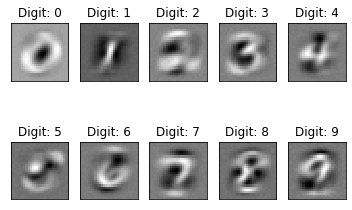

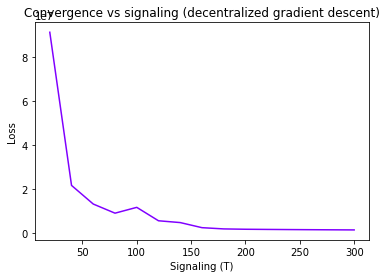

In [101]:
# ------------------------------plot greyscale models and master loss for DGD ----------------
# complete the plot 
plot_w_ks(curves['decentralized gradient descent']['no compression'][0])
plot_master_loss('decentralized gradient descent')

In [110]:
## CA5---------------------------- Part (b)------------------------------------------------------------------------------

# Complete communication graph -----------------------
A = np.array(
    [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [1, 1, 1, 1, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 1, 1, 1, 1], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

print(A)
# ----------------------------------------------------


[[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 1 1 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]]


In [0]:
#agent process for decentralized subgradient method (DSM)

def decentralized_subgradient_method_agent(Ai, x, y, w_k, lambda_, a_k):
# complete the following--------------------------------------   
    bar_w_k = w_k[Ai == 1].mean(axis = 0)
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_) 
    bar_w_k = bar_w_k - a_k * grad_w
    return Ai.sum() - 1, bar_w_k, grad_w

def decentralized_subgradient_method_agent_(args):
    return decentralized_subgradient_method_agent(*args)

# complete the following for ADMM --------------------------------------   
A_ADMM = A + np.diag(A).sum(axis = 0)

#agent process for ADMM
# complete the following--------------------------------------   
def admm_over_network_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = w_k[Ai == 1].mean(axis = 0) 
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_)
    bar_w_k = bar_w_k - a_k * grad_w
    return Ai.sum() - 1, bar_w_k, grad_w 

def admm_over_network_agent_(args):
    return admm_over_network_agent(*args)

#decentralized optimization over network
def decentralized_method(x, y, workers_x, workers_y, lambda_, a_k, max_iter, A, agent_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(num_worker, image_size, num_classes)
    T = 0
    errs = []
    ## Calculate L1 ------------------------------------------------
    L1 = regulated_total_cost(x, y, w_k.mean(axis = 0), lambda_) 
   
    for k in range(max_iter):
        L = L1
        #transmit w_ks and 
        workers_w_k = np.array(10 * [w_k]).reshape(10, 10, x.shape[0], 10)
        if compress is not None:
            compressed_w_k = np.zeros((10, x.shape[0], 10))
            for i in range(10):
                compressed_w_k[i] = compress(w_k[i])
            workers_w_k = np.array(10 * [compressed_w_k]).reshape(10, 10, x.shape[0], 10)
            for i in range(10):
                workers_w_k[i, i] = w_k[i]
        #each agent gets a copy of w_ks of neighbors, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(A, workers_x, workers_y, workers_w_k, 10 * [lambda_], 10 * [a_k])
        pool = ThreadPool(10)
        results = pool.map(agent_, zipped)
        pool.close()
        pool.join()

        # Complete signals, w_k, grad_w ------------------------------ 
        signals, w_k, grad_w = zip(*results) 
        grad_w = np.array(grad_w)
        w_k = np.array(w_k)

         # Complete T ------------------------------------------------
        T += np.array(signals).sum() 
        
         # Complete L1 ----------------------------------------------
        L1 = regulated_total_cost(x, y, w_k.mean(axis=0), lambda_) 
        L1s = []
        for i in range(10):
            L1s.append(regulated_total_cost(x, y, w_k[i], lambda_))
        errs.append((T, L1s))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w.mean(axis = 0))))
    return w_k.mean(axis = 0).reshape(x.shape[0],10), errs


In [112]:
# ---------------------------------------- Run DSM ------------------------------------------------------
print(datetime.now())
 # complete w_k, errs -------------------------
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_)
print(datetime.now())
y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))
curves['decentralized subgradient method'] = {'no compression':(w_k, errs)}

2020-04-11 13:10:08.569057
Final loss = 141667.250 and gradient norm = 933.462
2020-04-11 13:11:25.030323
Training classification error: 0.133
Test classification error: 0.124


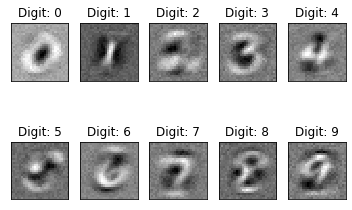

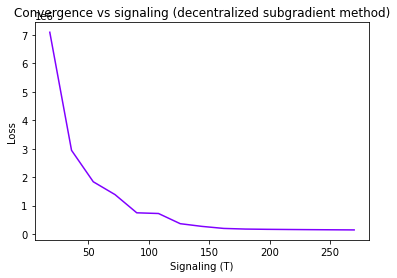

In [105]:
plot_w_ks(curves['decentralized subgradient method']['no compression'][0])
plot_agents_loss('decentralized subgradient method')

2020-04-11 12:57:45.818838
Final loss = 143886.972 and gradient norm = 1259.687
2020-04-11 12:59:02.462375
Training accuracy: 0.137
Test accuracy: 0.131


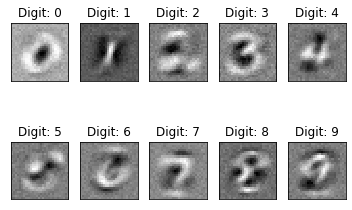

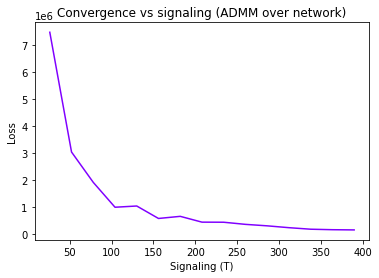

In [106]:
# ------------------------------------------Run ADMM ----------------------------------------------------
print(datetime.now())
# complete w_k, errs -------------------------
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training accuracy: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test accuracy: %.3f" % nmae(y_test, y_predict))

curves['ADMM over network'] = {'no compression':(w_k, errs)}

plot_w_ks(curves['ADMM over network']['no compression'][0])

plot_agents_loss('ADMM over network')

In [107]:
w_k_1, errs_1 = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, A_ADMM, admm_over_network_agent_)
w_k_2, errs_2 = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_)
w_k_3, errs_3 = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k3, max_iter, A_ADMM, admm_over_network_agent_)


Final loss = 1279977.168 and gradient norm = 847.939
Final loss = 141539.370 and gradient norm = 890.486
Final loss = 48542.566 and gradient norm = 3142.502


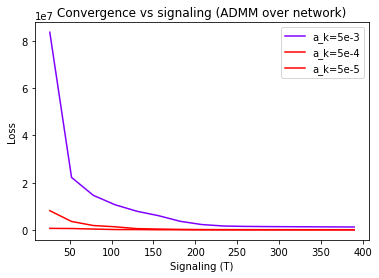

In [108]:
curves['ADMM over network'] = {'a_k=5e-3':(w_k_1, errs_1), 'a_k=5e-4':(w_k_2, errs_2), 'a_k=5e-5':(w_k_3, errs_3)}
plot_agents_loss('ADMM over network')

Final loss = 1271461.800 and gradient norm = 860.644
Final loss = 1269316.935 and gradient norm = 863.153


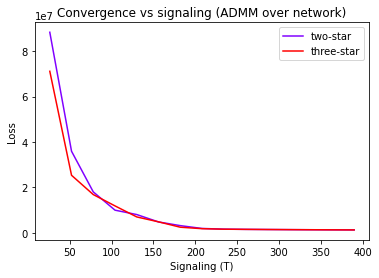

In [109]:
## CA5---------------------------- Part (c)------------------------------------------------------------------------------

A = np.array(
    [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [1, 1, 1, 1, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 1, 1, 1, 1], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

w_k_1, errs_1 = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, A_ADMM, admm_over_network_agent_)

A = np.array(
    [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 
     [1, 1, 1, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 1, 0, 1, 1, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 1, 0, 0, 0, 0, 1, 1], 
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

w_k_2, errs_2 = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, A_ADMM, admm_over_network_agent_)

curves['ADMM over network'] = {'two-star':(w_k_1, errs_1), 'three-star':(w_k_2, errs_2)}
plot_agents_loss('ADMM over network')


In [0]:
## CA6---------------------------- Part (a)------------------------------------------------------------------------------

# Complete Q1 and Q2 compression functions here -----------------------

# Repeat part a-b from CA5 using Q1 and Q2 compression functions here -----------------------
